# CNN Tutorial with PyTorch on the MNIST Dataset

In this tutorial, we will build a Convolutional Neural Network (CNN) to classify handwritten digits from the MNIST dataset. We'll go through the following steps:

1. **Data Loading, Processing, and Augmentation**
2. **Data Exploration**
3. **Model Building**
4. **Model Training**
5. **Model Evaluation**



## 1. Data Loading, Processing, and Augmentation

The MNIST dataset consists of 28x28 pixel grayscale images of handwritten digits (0-9). We'll use PyTorch's `torchvision` to load and preprocess the data. We will also apply some augmentations to improve our model's robustness.

### Exercise

1. Import the necessary libraries.
2. Load the MNIST dataset using `torchvision.datasets`.
3. Apply normalization to the dataset.
4. Create data loaders for training and testing with appropriate batch sizes.
5. Experiment with different data augmentations like rotation, translation, and flipping.

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [0, 1]
])

# Load the training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

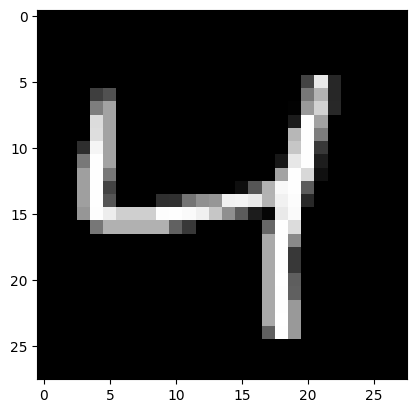

In [3]:
import matplotlib.pyplot as plt

example_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),  # Rotate by a random angle
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translate by a random fraction
    transforms.RandomHorizontalFlip(p=0.5)  # Flip horizontally with a 50% probability
])

# Apply the transformations to a sample image
example_image = train_dataset[2][0]
# show the original image
plt.imshow(example_image.numpy().squeeze(), cmap='gray')

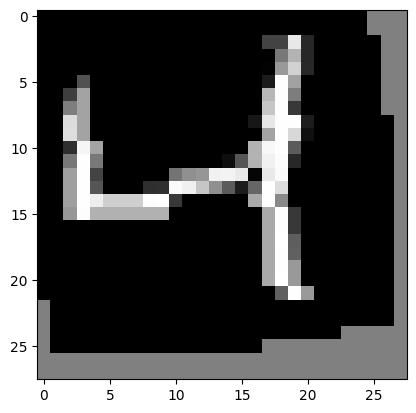

In [4]:
transformed_image = example_transform(example_image)
plt.imshow(transformed_image.numpy().squeeze(), cmap='gray')

## 2. Data Exploration

Before training our model, it's essential to explore the data. This helps us understand its distribution and visualize some examples.

### Exercise
1. Visualize a few images from the training dataset along with their labels.
2. Print the number of samples in the training and test datasets.

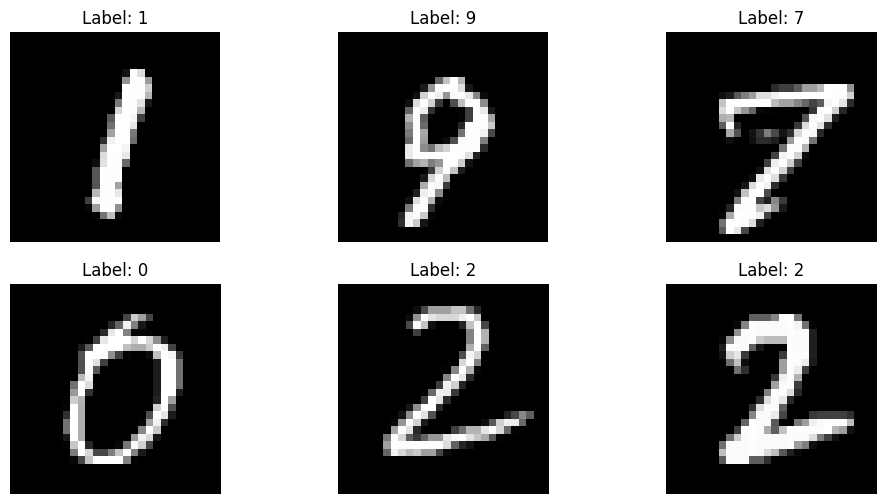

Training samples: 60000
Test samples: 10000


In [4]:
import matplotlib.pyplot as plt

# Function to display images
def show_images(images, labels):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Get some samples from the training dataset
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show images
show_images(images, labels)

# Print dataset sizes
print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

## 3. Model Building

Now, we'll define our CNN architecture. A typical CNN consists of convolutional layers, activation functions, pooling layers, and a fully connected output layer.

### Exercise
1. Define a CNN class inheriting from torch.nn.Module.
2. Include two convolutional layers, ReLU activations, max pooling, and a fully connected layer.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input: 1 channel, Output: 32 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Input: 32 channels, Output: 64 channels
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU, Input size: 28x28, 1 channel, Output size: 28x28, 32 channels
        x = F.max_pool2d(x, 2)  # Max pooling, Output size: 14x14 (max pooling with kernel size 2 reduces dimensions by half)
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU, Output size: 14x14, 64 channels
        x = F.max_pool2d(x, 2)  # Max pooling, Output size: 7x7 (max pooling with kernel size 2 reduces dimensions by half)
        x = x.view(x.size(0), -1)  # Flatten the output for each image to 1D tensor (7x7x64 = 3136)
        x = F.relu(self.fc1(x))  # Fully connected layer, Input size: 3136, Output size: 128
        x = self.fc2(x)  # Output layer, Input size: 128, Output size: 10 (10 classes)
        return x

# Create the model instance
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 4. Model Training

We'll now define the training loop to optimize our model using the cross-entropy loss function and the Adam optimizer.

### Exercise
1. Define a function to train the model for a specified number of epochs.
2. Print the training loss after each epoch.

In [6]:
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            
            running_loss += loss.item()  # Accumulate loss
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Count correct predictions
        
        # Calculate average loss and accuracy
        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Train the model
train(model, train_loader, criterion, optimizer, epochs=5)

Epoch [1/5], Loss: 0.1620, Accuracy: 94.94%
Epoch [2/5], Loss: 0.0458, Accuracy: 98.59%
Epoch [3/5], Loss: 0.0322, Accuracy: 99.04%
Epoch [4/5], Loss: 0.0235, Accuracy: 99.22%
Epoch [5/5], Loss: 0.0171, Accuracy: 99.47%


## 5. Model Evaluation

After training, we need to evaluate our model on the test dataset to understand its performance.

### Exercise
1. Define a function to evaluate the model's accuracy on the test set.
2. Print the accuracy.

In [7]:
import torch

def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Count correct predictions
            
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

# Evaluate the model
evaluate(model, test_loader)

Accuracy of the model on the test set: 99.01%
